Using wind-speed variable: wind_speed ('season', 'y', 'x')
Averaged over: season
Raster CRS: EPSG:27700
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_cf_proxy.tif
CF proxy min/max: 0.0 0.12287033349275589
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_cf_score.tif


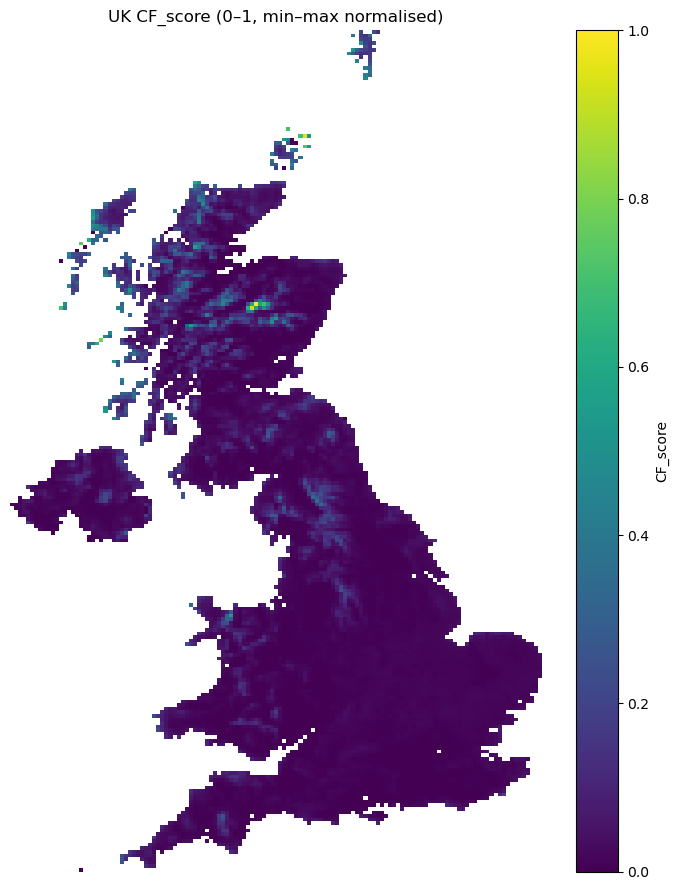

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_cf_score.png


In [3]:
import os
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray  

BASE = "/Users/jsh/Desktop/assignment2 spatial"
in_nc = os.path.join(BASE, "wind_speed.nc")
boundary_fp = os.path.join(BASE, "uk boundary.geojson")

out_cf_proxy_tif = os.path.join(BASE, "uk_cf_proxy.tif")
out_cf_score_tif = os.path.join(BASE, "uk_cf_score.tif")
out_png = os.path.join(BASE, "uk_cf_score.png")

ds = xr.open_dataset(in_nc)
ws = ds["wind_speed"]  
print("Using wind-speed variable:", ws.name, ws.dims)


if "season" in ws.dims:
    ws = ws.mean("season")
    print("Averaged over: season")

v_ci, v_r, v_co = 3.0, 12.0, 25.0
v = ws.astype("float32")

cf = xr.where(v < v_ci, 0.0,
      xr.where(v < v_r, ((v - v_ci) / (v_r - v_ci))**3,
      xr.where(v <= v_co, 1.0, 0.0))).astype("float32")
cf.name = "cf_proxy"

cf = cf.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)


crs = None
if "spatial_ref" in ds.variables:
    attrs = ds["spatial_ref"].attrs
    crs = attrs.get("crs_wkt") or attrs.get("spatial_ref")
if crs is None:
    crs = "EPSG:27700"   

cf = cf.rio.write_crs(crs, inplace=False)
print("Raster CRS:", cf.rio.crs)


uk = gpd.read_file(boundary_fp).to_crs(cf.rio.crs)
cf_clip = cf.rio.clip(uk.geometry, uk.crs, drop=True)


cf_clip.rio.to_raster(out_cf_proxy_tif)
print("Saved:", out_cf_proxy_tif)


arr = cf_clip.values
valid = np.isfinite(arr)
vmin = float(np.nanmin(arr[valid]))
vmax = float(np.nanmax(arr[valid]))
print("CF proxy min/max:", vmin, vmax)

cf_score = (cf_clip - vmin) / (vmax - vmin)
cf_score = cf_score.clip(0, 1)
cf_score.name = "CF_score"

cf_score.rio.to_raster(out_cf_score_tif)
print("Saved:", out_cf_score_tif)


plt.figure(figsize=(7, 9))
cf_score.plot(vmin=0, vmax=1)
plt.title("UK CF_score (0–1, min–max normalised)")
plt.axis("off")
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()
print("Saved:", out_png)


Template CRS: EPSG:27700 Resolution(m): 5000.0 5000.0
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_transmission_m.tif
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_grid_score.tif


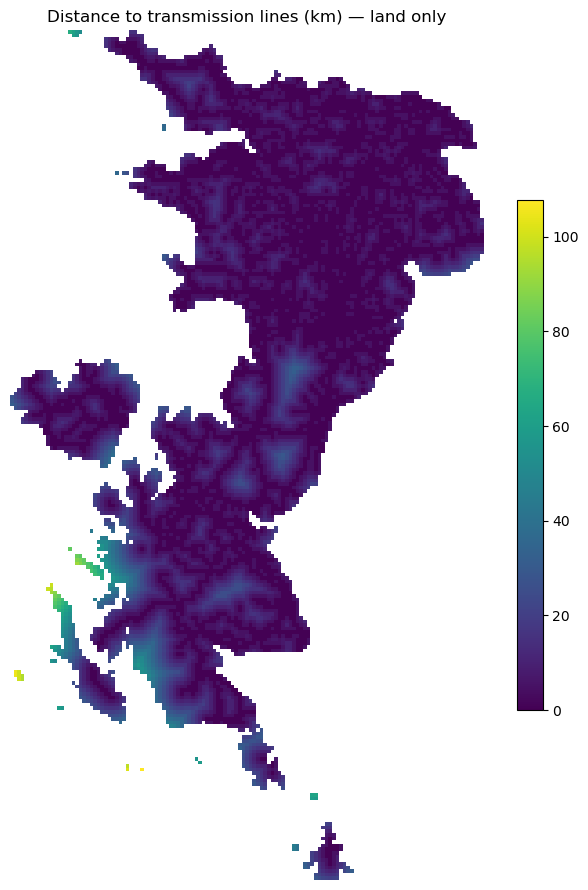

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_transmission_m.png


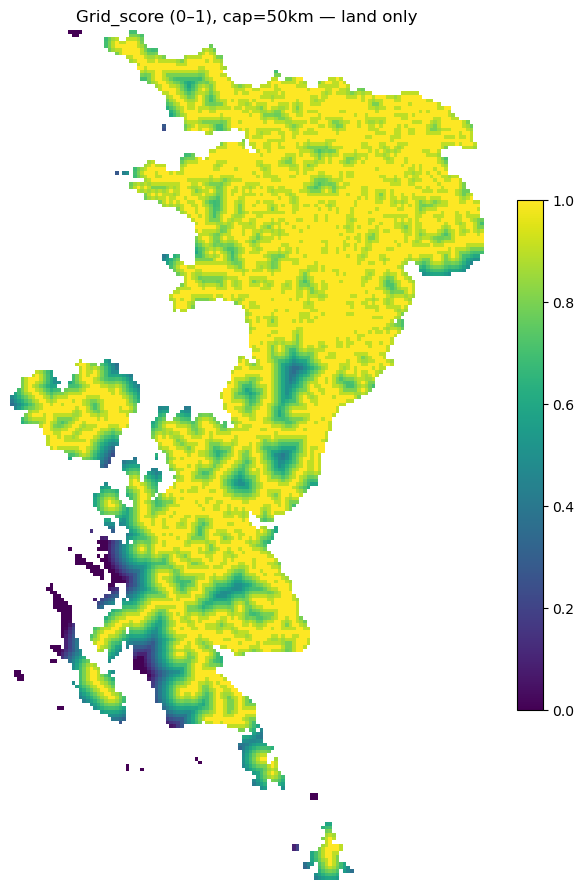

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_grid_score.png


In [6]:
import rasterio
from rasterio.features import rasterize
from scipy.ndimage import distance_transform_edt

BASE = "/Users/jsh/Desktop/assignment2 spatial"

template_tif = os.path.join(BASE, "uk_cf_score.tif")                 
boundary_fp  = os.path.join(BASE, "uk boundary.geojson")             
lines_fp     = os.path.join(BASE, "uk_transmission_lines.geojson")   
out_dist_tif  = os.path.join(BASE, "uk_dist_to_transmission_m.tif")
out_score_tif = os.path.join(BASE, "uk_grid_score.tif")
out_dist_png  = os.path.join(BASE, "uk_dist_to_transmission_m.png")
out_score_png = os.path.join(BASE, "uk_grid_score.png")


CAP_KM = 50.0   
CAP_M  = CAP_KM * 1000.0

nodata_val = -9999.0


with rasterio.open(template_tif) as src:
    meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    height, width = src.height, src.width
    template = src.read(1)
    template_nodata = src.nodata

xres = abs(transform.a)
yres = abs(transform.e)
print("Template CRS:", crs, "Resolution(m):", xres, yres)


uk = gpd.read_file(boundary_fp).to_crs(crs)
uk_mask = rasterize(
    [(geom, 1) for geom in uk.geometry if geom is not None],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
).astype(bool) 


lines = gpd.read_file(lines_fp).to_crs(crs)


line_raster = rasterize(
    [(geom, 1) for geom in lines.geometry if geom is not None],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
)

binary = np.ones((height, width), dtype=np.uint8)
binary[line_raster == 1] = 0

dist_m = distance_transform_edt(binary, sampling=(yres, xres)).astype("float32")


dist_m = np.where(uk_mask, dist_m, nodata_val)


meta_out = meta.copy()
meta_out.update(dtype="float32", nodata=nodata_val, count=1)

with rasterio.open(out_dist_tif, "w", **meta_out) as dst:
    dst.write(dist_m, 1)
print("Saved:", out_dist_tif)

valid = (dist_m != nodata_val) & np.isfinite(dist_m)

dist_cap = np.where(valid, np.minimum(dist_m, CAP_M), nodata_val)

dist_norm = np.where(valid, dist_cap / CAP_M, np.nan)       
grid_score = np.where(valid, 1.0 - dist_norm, nodata_val)   
grid_score = np.clip(grid_score, 0, 1).astype("float32")

with rasterio.open(out_score_tif, "w", **meta_out) as dst:
    dst.write(grid_score, 1)
print("Saved:", out_score_tif)

plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, dist_m/1000.0, np.nan))  # km
plt.title(f"Distance to transmission lines (km) — land only")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_dist_png, dpi=300)
plt.show()
print("Saved:", out_dist_png)

plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, grid_score, np.nan), vmin=0, vmax=1)
plt.title(f"Grid_score (0–1), cap={CAP_KM:.0f}km — land only")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_score_png, dpi=300)
plt.show()
print("Saved:", out_score_png)


Template CRS: EPSG:27700
Resolution (m): 5000.0 5000.0
Shape: (235, 131)
Saved distance raster: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_transmission_m.tif
Saved grid score: /Users/jsh/Desktop/assignment2 spatial/uk_grid_score.tif


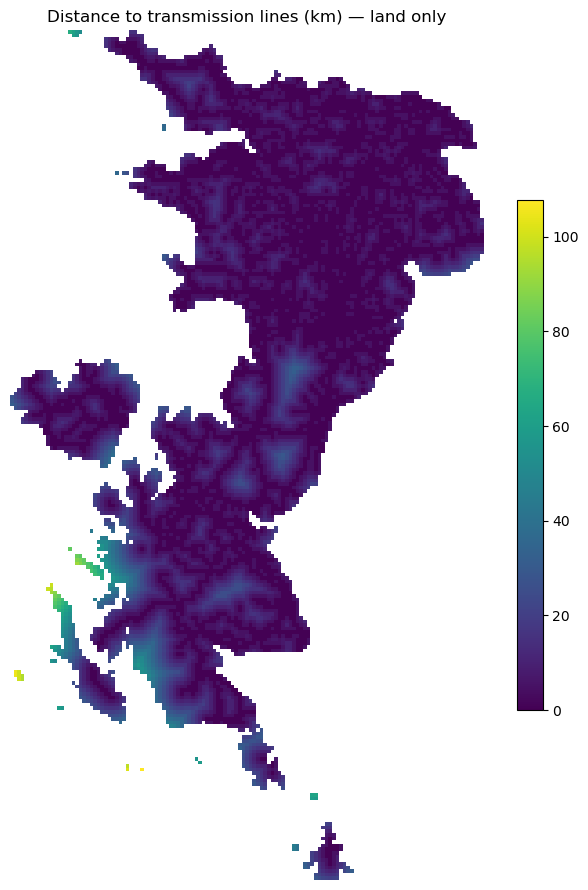

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_transmission_m.png


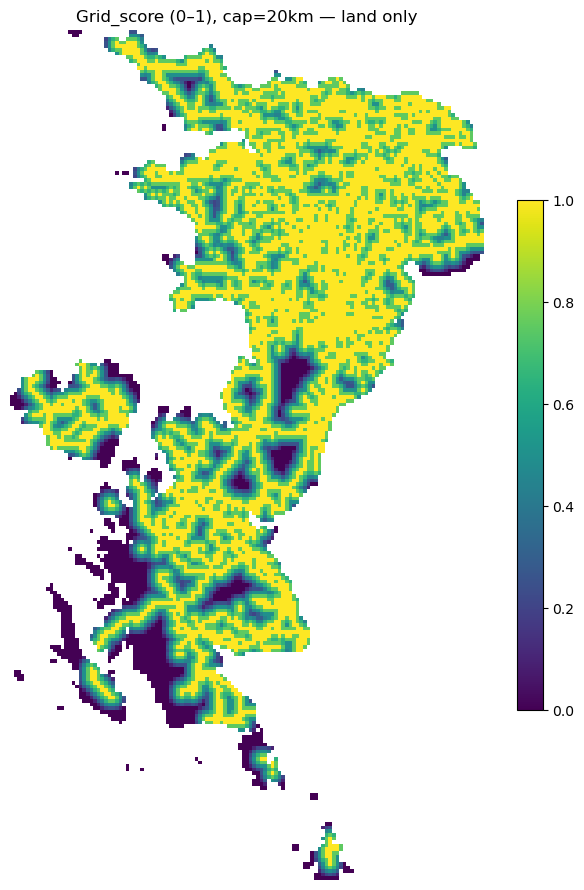

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_grid_score.png


In [7]:
BASE = "/Users/jsh/Desktop/assignment2 spatial"

# Inputs
template_tif = os.path.join(BASE, "uk_cf_score.tif")                 
boundary_fp  = os.path.join(BASE, "uk boundary.geojson")            
lines_fp     = os.path.join(BASE, "uk_transmission_lines.geojson")  

# Outputs
out_dist_tif  = os.path.join(BASE, "uk_dist_to_transmission_m.tif")  
out_score_tif = os.path.join(BASE, "uk_grid_score.tif")              
out_dist_png  = os.path.join(BASE, "uk_dist_to_transmission_m.png")
out_score_png = os.path.join(BASE, "uk_grid_score.png")


CAP_KM = 20.0          
CAP_M  = CAP_KM * 1000.0

nodata_val = -9999.0

# -------------------------
# 1) Read template raster metadata
# -------------------------
with rasterio.open(template_tif) as src:
    meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    height, width = src.height, src.width
    template = src.read(1)

xres = abs(transform.a)
yres = abs(transform.e)
print("Template CRS:", crs)
print("Resolution (m):", xres, yres)
print("Shape:", (height, width))


uk = gpd.read_file(boundary_fp).to_crs(crs)
land_mask = rasterize(
    [(geom, 1) for geom in uk.geometry if geom is not None],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
).astype(bool)


lines = gpd.read_file(lines_fp).to_crs(crs)


line_raster = rasterize(
    [(geom, 1) for geom in lines.geometry if geom is not None],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
)


binary = np.ones((height, width), dtype=np.uint8)
binary[line_raster == 1] = 0

dist_m = distance_transform_edt(binary, sampling=(yres, xres)).astype("float32")


dist_m = np.where(land_mask, dist_m, nodata_val)


meta_out = meta.copy()
meta_out.update(dtype="float32", nodata=nodata_val, count=1)

with rasterio.open(out_dist_tif, "w", **meta_out) as dst:
    dst.write(dist_m, 1)

print("Saved distance raster:", out_dist_tif)


valid = (dist_m != nodata_val) & np.isfinite(dist_m)

dist_cap = np.where(valid, np.minimum(dist_m, CAP_M), np.nan)
grid_score = np.where(valid, 1.0 - (dist_cap / CAP_M), nodata_val).astype("float32")
grid_score = np.clip(grid_score, 0, 1)

with rasterio.open(out_score_tif, "w", **meta_out) as dst:
    dst.write(grid_score, 1)

print("Saved grid score:", out_score_tif)


plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, dist_m / 1000.0, np.nan))  # km
plt.title("Distance to transmission lines (km) — land only")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_dist_png, dpi=300)
plt.show()
print("Saved:", out_dist_png)

plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, grid_score, np.nan), vmin=0, vmax=1)
plt.title(f"Grid_score (0–1), cap={CAP_KM:.0f}km — land only")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_score_png, dpi=300)
plt.show()
print("Saved:", out_score_png)


Template CRS: EPSG:27700
Resolution (m): 5000.0 5000.0 Pixel: 5000.0
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_substations_275_400_m.tif /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_275_400.tif
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_substations_132_m.tif /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_132.tif
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_combined.tif


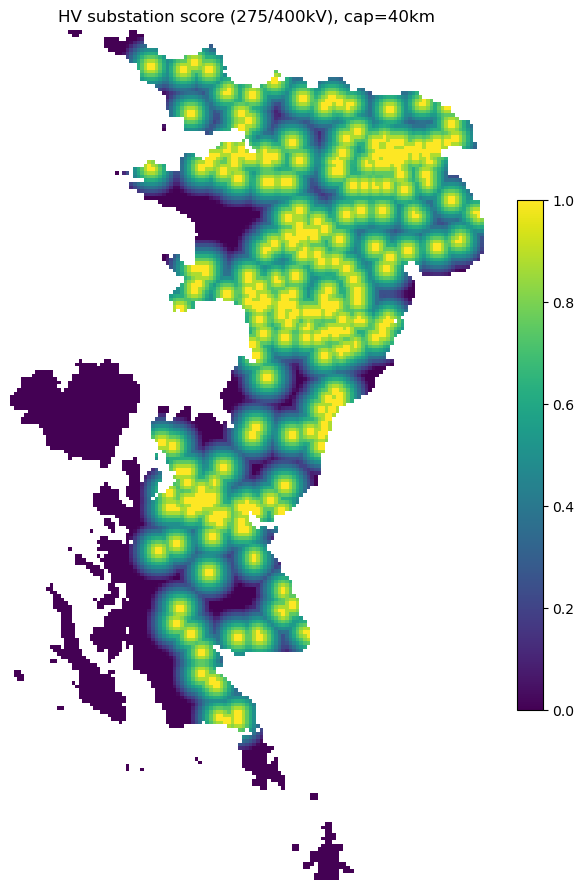

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_275_400.png


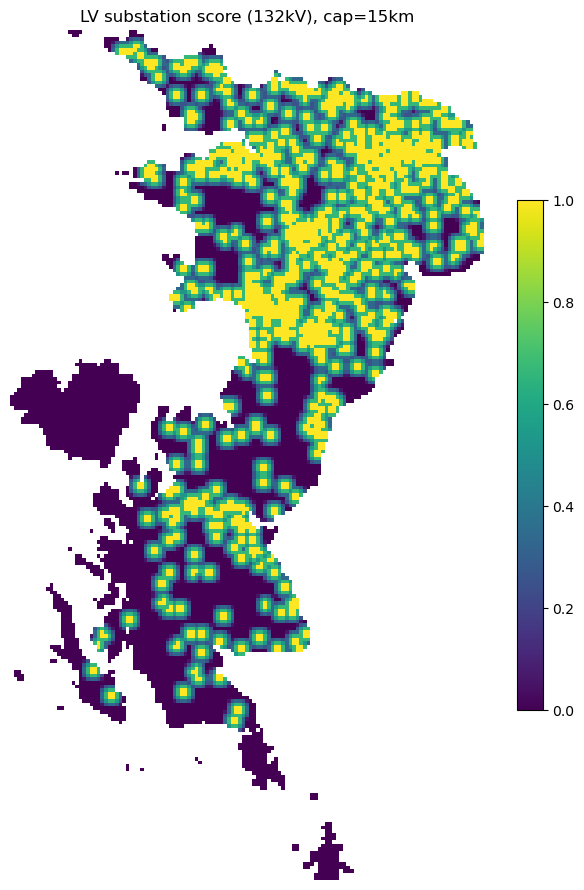

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_132.png


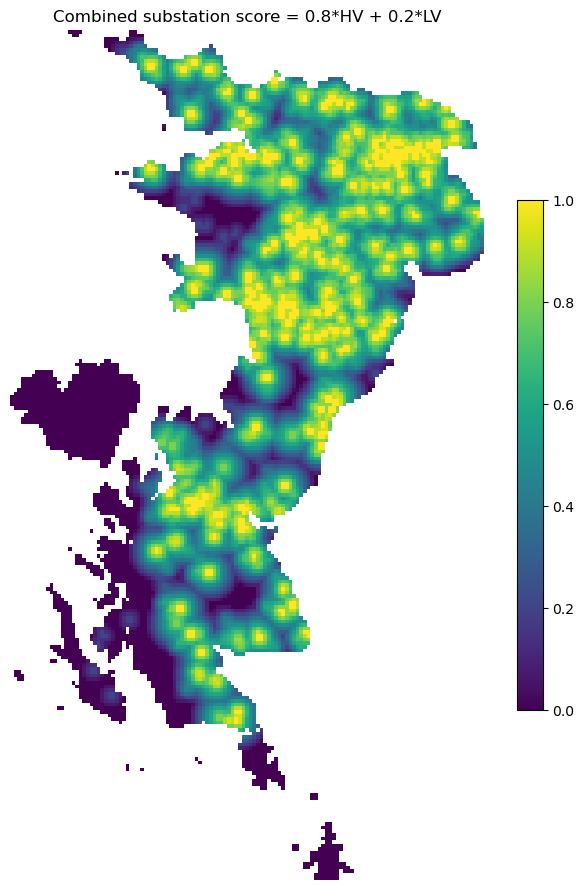

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_combined.png


In [8]:
BASE = "/Users/jsh/Desktop/assignment2 spatial"


template_tif = os.path.join(BASE, "uk_cf_score.tif")  


hv_fp = os.path.join(BASE, "gb_substations_275_400_epsg27700.geojson") 
lv_fp = os.path.join(BASE, "gb_substations_132_epsg27700.geojson")     
boundary_fp = os.path.join(BASE, "uk boundary.geojson")


out_hv_dist  = os.path.join(BASE, "uk_dist_to_substations_275_400_m.tif")
out_hv_score = os.path.join(BASE, "uk_substation_score_275_400.tif")

out_lv_dist  = os.path.join(BASE, "uk_dist_to_substations_132_m.tif")
out_lv_score = os.path.join(BASE, "uk_substation_score_132.tif")

out_combined = os.path.join(BASE, "uk_substation_score_combined.tif")

out_png_hv = os.path.join(BASE, "uk_substation_score_275_400.png")
out_png_lv = os.path.join(BASE, "uk_substation_score_132.png")
out_png_cb = os.path.join(BASE, "uk_substation_score_combined.png")

nodata_val = -9999.0


CAP_HV_KM = 40.0    

CAP_LV_KM = 15.0    

W_HV = 0.8
W_LV = 0.2


with rasterio.open(template_tif) as src:
    meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    height, width = src.height, src.width

xres = abs(transform.a)
yres = abs(transform.e)
pix = max(xres, yres)

print("Template CRS:", crs)
print("Resolution (m):", xres, yres, "Pixel:", pix)

meta_out = meta.copy()
meta_out.update(dtype="float32", nodata=nodata_val, count=1)


uk = gpd.read_file(boundary_fp).to_crs(crs)
land_mask = rasterize(
    [(geom, 1) for geom in uk.geometry if geom is not None],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
).astype(bool)


def point_distance_and_score(points_gdf, cap_km, out_dist_tif, out_score_tif):
    cap_m = cap_km * 1000.0


    buf = pix * 0.5
    geoms = [g.buffer(buf) for g in points_gdf.geometry if g is not None]

    pt_ras = rasterize(
        [(geom, 1) for geom in geoms],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        all_touched=True,
        dtype="uint8"
    )


    binary = np.ones((height, width), dtype=np.uint8)
    binary[pt_ras == 1] = 0

    dist_m = distance_transform_edt(binary, sampling=(yres, xres)).astype("float32")
    dist_m = np.where(land_mask, dist_m, nodata_val)

    valid = (dist_m != nodata_val) & np.isfinite(dist_m)
    dist_cap = np.where(valid, np.minimum(dist_m, cap_m), np.nan)
    score = np.where(valid, 1.0 - (dist_cap / cap_m), nodata_val).astype("float32")
    score = np.clip(score, 0, 1)

    with rasterio.open(out_dist_tif, "w", **meta_out) as dst:
        dst.write(dist_m, 1)
    with rasterio.open(out_score_tif, "w", **meta_out) as dst:
        dst.write(score, 1)

    return dist_m, score, valid

hv = gpd.read_file(hv_fp).to_crs(crs)
hv_dist, hv_score, hv_valid = point_distance_and_score(
    hv, CAP_HV_KM, out_hv_dist, out_hv_score
)
print("Saved:", out_hv_dist, out_hv_score)


lv = gpd.read_file(lv_fp).to_crs(crs)
lv_dist, lv_score, lv_valid = point_distance_and_score(
    lv, CAP_LV_KM, out_lv_dist, out_lv_score
)
print("Saved:", out_lv_dist, out_lv_score)


valid = land_mask  
combined = (W_HV * hv_score + W_LV * lv_score).astype("float32")
combined = np.where(valid, combined, nodata_val)

with rasterio.open(out_combined, "w", **meta_out) as dst:
    dst.write(combined, 1)

print("Saved:", out_combined)


plt.figure(figsize=(7, 9))
plt.imshow(np.where(hv_valid, hv_score, np.nan), vmin=0, vmax=1)
plt.title(f"HV substation score (275/400kV), cap={CAP_HV_KM:.0f}km")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_png_hv, dpi=300)
plt.show()
print("Saved:", out_png_hv)

plt.figure(figsize=(7, 9))
plt.imshow(np.where(lv_valid, lv_score, np.nan), vmin=0, vmax=1)
plt.title(f"LV substation score (132kV), cap={CAP_LV_KM:.0f}km")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_png_lv, dpi=300)
plt.show()
print("Saved:", out_png_lv)

plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, combined, np.nan), vmin=0, vmax=1)
plt.title(f"Combined substation score = {W_HV:.1f}*HV + {W_LV:.1f}*LV")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_png_cb, dpi=300)
plt.show()
print("Saved:", out_png_cb)


Template CRS: EPSG:27700
Resolution (m): 5000.0 5000.0 Pixel: 5000.0
Shape: (235, 131)
[HV 275/400] points: 516 | saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_substations_275_400_m.tif /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_275_400.tif
[LV 132/110] points: 1222 | saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_substations_132_110_m.tif /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_132_110.tif
Saved combined: /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_combined.tif


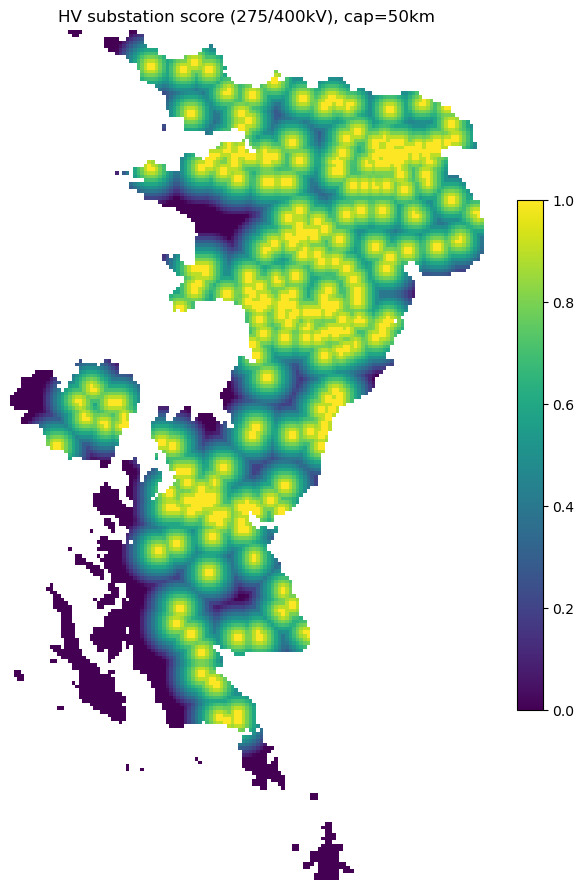

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_275_400.png


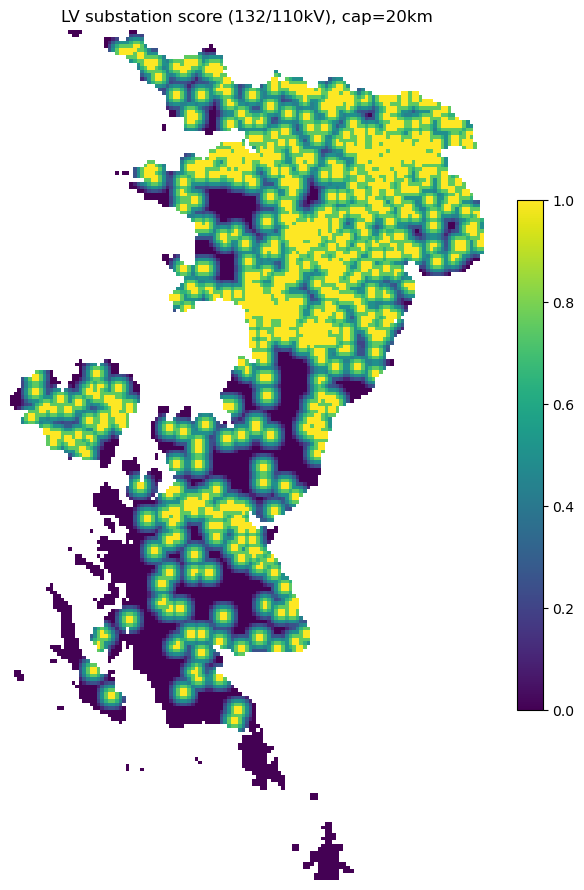

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_132_110.png


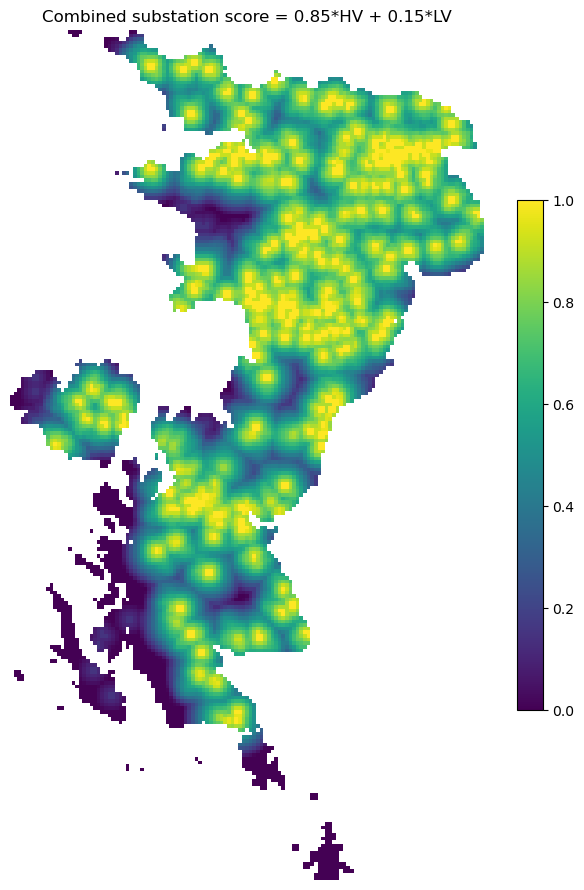

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_substation_score_combined.png


In [9]:
BASE = "/Users/jsh/Desktop/assignment2 spatial"


template_tif = os.path.join(BASE, "uk_cf_score.tif") 
boundary_fp  = os.path.join(BASE, "uk boundary.geojson")

# ✅ updated substations (GB + NI)
hv_fp = os.path.join(BASE, "uk_core_nodes_275_400_epsg27700.geojson")           
lv_fp = os.path.join(BASE, "uk_backup_nodes_132_GB_plus_110_NI_epsg27700.geojson") 

# -----------------------------
# Outputs
# -----------------------------
out_hv_dist  = os.path.join(BASE, "uk_dist_to_substations_275_400_m.tif")
out_hv_score = os.path.join(BASE, "uk_substation_score_275_400.tif")

out_lv_dist  = os.path.join(BASE, "uk_dist_to_substations_132_110_m.tif")
out_lv_score = os.path.join(BASE, "uk_substation_score_132_110.tif")

out_combined = os.path.join(BASE, "uk_substation_score_combined.tif")

out_png_hv = os.path.join(BASE, "uk_substation_score_275_400.png")
out_png_lv = os.path.join(BASE, "uk_substation_score_132_110.png")
out_png_cb = os.path.join(BASE, "uk_substation_score_combined.png")

nodata_val = -9999.0

CAP_HV_KM = 50.0   
CAP_LV_KM = 20.0  

W_HV = 0.85
W_LV = 0.15


with rasterio.open(template_tif) as src:
    meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    height, width = src.height, src.width

xres = abs(transform.a)
yres = abs(transform.e)
pix = max(xres, yres)

print("Template CRS:", crs)
print("Resolution (m):", xres, yres, "Pixel:", pix)
print("Shape:", (height, width))

meta_out = meta.copy()
meta_out.update(dtype="float32", nodata=nodata_val, count=1)


uk = gpd.read_file(boundary_fp).to_crs(crs)
land_mask = rasterize(
    [(geom, 1) for geom in uk.geometry if geom is not None],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
).astype(bool)


def point_distance_and_score(points_gdf, cap_km, out_dist_tif, out_score_tif, label=""):
    cap_m = cap_km * 1000.0

    buf = pix * 0.5
    geoms = [g.buffer(buf) for g in points_gdf.geometry if g is not None and not g.is_empty]

    if len(geoms) == 0:
        raise ValueError(f"[{label}] No valid geometries after buffering. Check the input file.")

    pt_ras = rasterize(
        [(geom, 1) for geom in geoms],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        all_touched=True,
        dtype="uint8"
    )

    binary = np.ones((height, width), dtype=np.uint8)
    binary[pt_ras == 1] = 0

    dist_m = distance_transform_edt(binary, sampling=(yres, xres)).astype("float32")
    dist_m = np.where(land_mask, dist_m, nodata_val)

    valid = (dist_m != nodata_val) & np.isfinite(dist_m)

    dist_cap = np.where(valid, np.minimum(dist_m, cap_m), np.nan)
    score = np.where(valid, 1.0 - (dist_cap / cap_m), nodata_val).astype("float32")
    score = np.clip(score, 0, 1)

    with rasterio.open(out_dist_tif, "w", **meta_out) as dst:
        dst.write(dist_m, 1)
    with rasterio.open(out_score_tif, "w", **meta_out) as dst:
        dst.write(score, 1)

    print(f"[{label}] points:", len(points_gdf), "| saved:", out_dist_tif, out_score_tif)
    return dist_m, score, valid


hv = gpd.read_file(hv_fp).to_crs(crs)
hv_dist, hv_score, hv_valid = point_distance_and_score(
    hv, CAP_HV_KM, out_hv_dist, out_hv_score, label="HV 275/400"
)


lv = gpd.read_file(lv_fp).to_crs(crs)
lv_dist, lv_score, lv_valid = point_distance_and_score(
    lv, CAP_LV_KM, out_lv_dist, out_lv_score, label="LV 132/110"
)


valid = land_mask & (hv_score != nodata_val) & (lv_score != nodata_val)
combined = np.full((height, width), nodata_val, dtype="float32")
combined[valid] = W_HV * hv_score[valid] + W_LV * lv_score[valid]
combined = np.clip(combined, 0, 1)

with rasterio.open(out_combined, "w", **meta_out) as dst:
    dst.write(combined, 1)

print("Saved combined:", out_combined)

plt.figure(figsize=(7, 9))
plt.imshow(np.where(hv_valid, hv_score, np.nan), vmin=0, vmax=1)
plt.title(f"HV substation score (275/400kV), cap={CAP_HV_KM:.0f}km")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_png_hv, dpi=300)
plt.show()
print("Saved:", out_png_hv)

plt.figure(figsize=(7, 9))
plt.imshow(np.where(lv_valid, lv_score, np.nan), vmin=0, vmax=1)
plt.title(f"LV substation score (132/110kV), cap={CAP_LV_KM:.0f}km")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_png_lv, dpi=300)
plt.show()
print("Saved:", out_png_lv)

plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, combined, np.nan), vmin=0, vmax=1)
plt.title(f"Combined substation score = {W_HV:.2f}*HV + {W_LV:.2f}*LV")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_png_cb, dpi=300)
plt.show()
print("Saved:", out_png_cb)


Template CRS: EPSG:27700
Resolution (m): 5000.0 5000.0 Pixel: 5000.0
Shape: (235, 131)
fiona not available; trying default layer read...


/opt/anaconda3/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


Saved distance raster: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_major_roads_m.tif
Saved road score: /Users/jsh/Desktop/assignment2 spatial/uk_road_score.tif


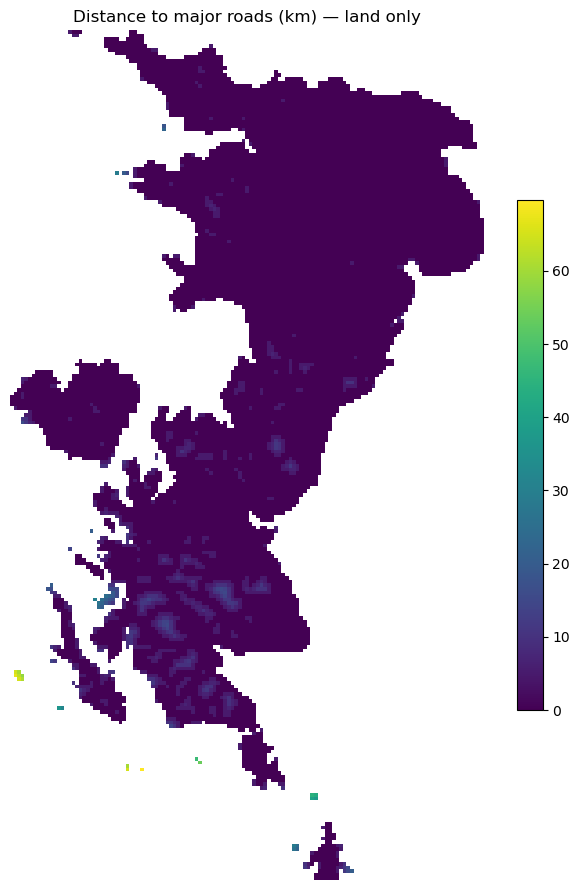

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_major_roads_m.png


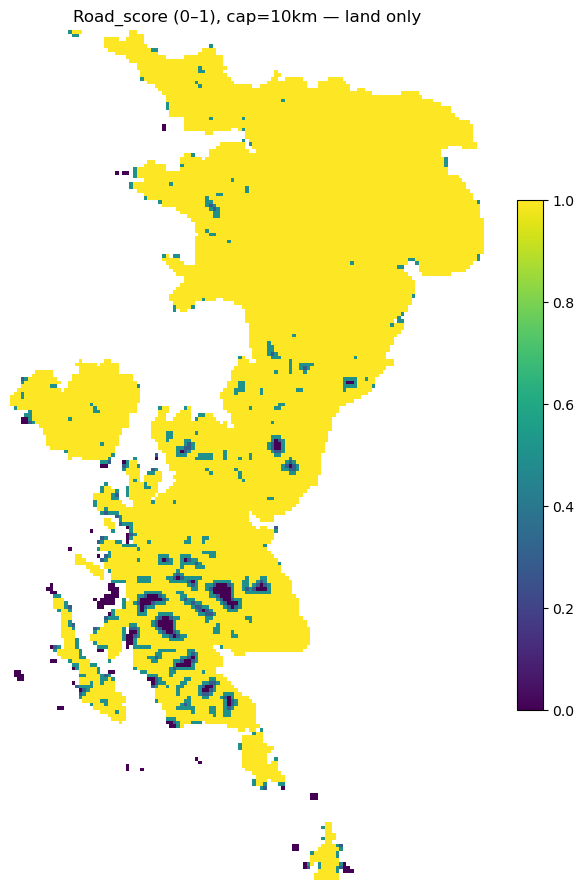

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_road_score.png


In [10]:
try:
    import fiona
    HAS_FIONA = True
except Exception:
    HAS_FIONA = False

BASE = "/Users/jsh/Desktop/assignment2 spatial"

template_tif = os.path.join(BASE, "uk_cf_score.tif")               
boundary_fp  = os.path.join(BASE, "uk boundary.geojson")          
roads_gpkg   = os.path.join(BASE, "uk_major_roads_epsg3035.gpkg")  

out_dist_tif  = os.path.join(BASE, "uk_dist_to_major_roads_m.tif")
out_score_tif = os.path.join(BASE, "uk_road_score.tif")
out_dist_png  = os.path.join(BASE, "uk_dist_to_major_roads_m.png")
out_score_png = os.path.join(BASE, "uk_road_score.png")

CAP_KM = 10.0      
CAP_M  = CAP_KM * 1000.0
nodata_val = -9999.0


mask_tif = None


with rasterio.open(template_tif) as src:
    meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    height, width = src.height, src.width

xres = abs(transform.a)
yres = abs(transform.e)
pix = max(xres, yres)

print("Template CRS:", crs)
print("Resolution (m):", xres, yres, "Pixel:", pix)
print("Shape:", (height, width))

meta_out = meta.copy()
meta_out.update(dtype="float32", nodata=nodata_val, count=1)


uk = gpd.read_file(boundary_fp).to_crs(crs)
land_mask = rasterize(
    [(geom, 1) for geom in uk.geometry if geom is not None],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
).astype(bool)


layer = None
if HAS_FIONA:
    layers = fiona.listlayers(roads_gpkg)
    if len(layers) == 0:
        raise ValueError("No layers found in the roads GPKG.")
    layer = layers[0]
    print("Using GPKG layer:", layer)
    roads = gpd.read_file(roads_gpkg, layer=layer)
else:
    print("fiona not available; trying default layer read...")
    roads = gpd.read_file(roads_gpkg)

roads = roads.to_crs(crs)


buf = pix * 0.5
geoms = []
for g in roads.geometry:
    if g is None or g.is_empty:
        continue
    geoms.append(g.buffer(buf))

roads_ras = rasterize(
    [(geom, 1) for geom in geoms],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
)


binary = np.ones((height, width), dtype=np.uint8)
binary[roads_ras == 1] = 0

dist_m = distance_transform_edt(binary, sampling=(yres, xres)).astype("float32")


dist_m = np.where(land_mask, dist_m, nodata_val)

if mask_tif is not None and os.path.exists(mask_tif):
    with rasterio.open(mask_tif) as msk:
        m = msk.read(1)
    dist_m = np.where(m == 1, nodata_val, dist_m)

with rasterio.open(out_dist_tif, "w", **meta_out) as dst:
    dst.write(dist_m, 1)
print("Saved distance raster:", out_dist_tif)


valid = (dist_m != nodata_val) & np.isfinite(dist_m)

dist_cap = np.where(valid, np.minimum(dist_m, CAP_M), np.nan)
road_score = np.where(valid, 1.0 - (dist_cap / CAP_M), nodata_val).astype("float32")
road_score = np.clip(road_score, 0, 1)

with rasterio.open(out_score_tif, "w", **meta_out) as dst:
    dst.write(road_score, 1)
print("Saved road score:", out_score_tif)


plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, dist_m/1000.0, np.nan))  # km
plt.title("Distance to major roads (km) — land only")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_dist_png, dpi=300)
plt.show()
print("Saved:", out_dist_png)

plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, road_score, np.nan), vmin=0, vmax=1)
plt.title(f"Road_score (0–1), cap={CAP_KM:.0f}km — land only")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_score_png, dpi=300)
plt.show()
print("Saved:", out_score_png)


In [14]:
vals = road_score[road_score != nodata_val]
print("min/median/mean/max:",
      float(np.nanmin(vals)),
      float(np.nanmedian(vals)),
      float(np.nanmean(vals)),
      float(np.nanmax(vals)))


min/median/mean/max: 0.0 0.0 0.30644795298576355 1.0


Template CRS: EPSG:27700
Resolution (m): 5000.0 5000.0 Pixel: 5000.0 Shape: (235, 131)
fiona not available -> read default layer
Roads original CRS: EPSG:3035
Roads reprojected CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","27700"]]
Road features: 421512


/opt/anaconda3/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


Road raster coverage (% of cells): 30.745492934870878
Score min/median/mean/max: 0.0 1.0 0.8492213487625122 1.0
Share with score==0 (dist>=cap): 0.1507786479431092


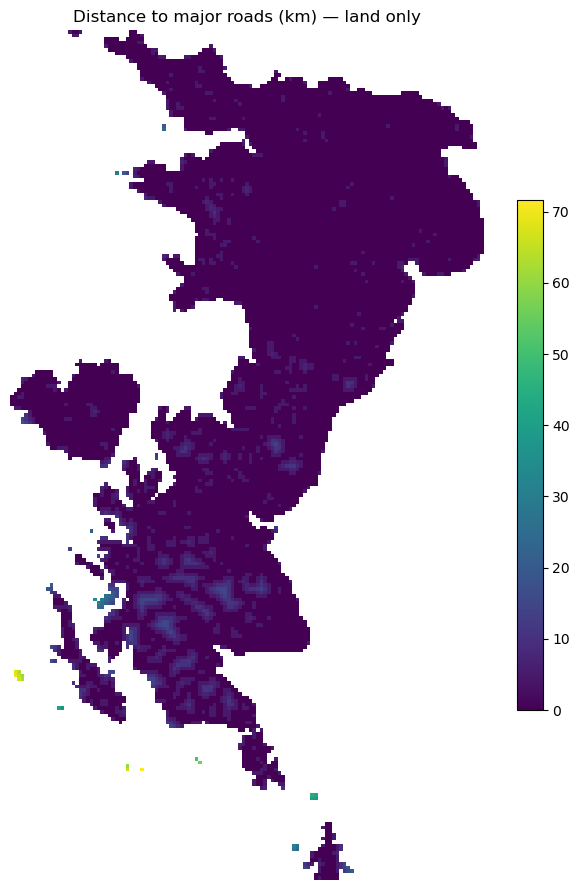

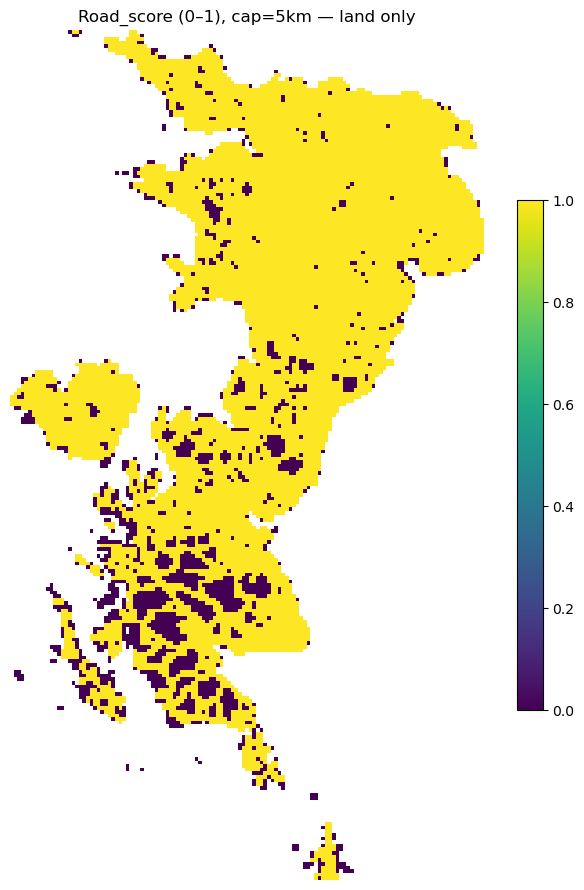

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_major_roads_m.tif
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_road_score.tif
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_major_roads_m.png
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_road_score.png


In [12]:
try:
    import fiona
    HAS_FIONA = True
except Exception:
    HAS_FIONA = False

BASE = "/Users/jsh/Desktop/assignment2 spatial"

template_tif = os.path.join(BASE, "uk_cf_score.tif")
boundary_fp  = os.path.join(BASE, "uk boundary.geojson")
roads_gpkg   = os.path.join(BASE, "uk_major_roads_epsg3035.gpkg")

out_dist_tif  = os.path.join(BASE, "uk_dist_to_major_roads_m.tif")
out_score_tif = os.path.join(BASE, "uk_road_score.tif")
out_png_dist  = os.path.join(BASE, "uk_dist_to_major_roads_m.png")
out_png_score = os.path.join(BASE, "uk_road_score.png")

nodata_val = -9999.0

CAP_KM = 5.0
CAP_M  = CAP_KM * 1000.0

BUF_FACTOR = 0.2  

with rasterio.open(template_tif) as src:
    meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    height, width = src.height, src.width

xres = abs(transform.a)
yres = abs(transform.e)
pix = max(xres, yres)

print("Template CRS:", crs)
print("Resolution (m):", xres, yres, "Pixel:", pix, "Shape:", (height, width))

meta_out = meta.copy()
meta_out.update(dtype="float32", nodata=nodata_val, count=1)


uk = gpd.read_file(boundary_fp).to_crs(crs)
land_mask = rasterize(
    [(geom, 1) for geom in uk.geometry if geom is not None],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
).astype(bool)


if HAS_FIONA:
    layers = fiona.listlayers(roads_gpkg)
    print("GPKG layers:", layers)
    layer = layers[0]
    roads = gpd.read_file(roads_gpkg, layer=layer)
    print("Using layer:", layer)
else:
    roads = gpd.read_file(roads_gpkg)
    print("fiona not available -> read default layer")

print("Roads original CRS:", roads.crs)
roads = roads.to_crs(crs)
print("Roads reprojected CRS:", roads.crs)
print("Road features:", len(roads))


buf = pix * BUF_FACTOR
geoms = []
for g in roads.geometry:
    if g is None or g.is_empty:
        continue
    geoms.append(g.buffer(buf))

if len(geoms) == 0:
    raise ValueError("No valid road geometries found after buffering.")

roads_ras = rasterize(
    [(geom, 1) for geom in geoms],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
)

print("Road raster coverage (% of cells):", 100.0 * roads_ras.mean())


binary = np.ones((height, width), dtype=np.uint8)
binary[roads_ras == 1] = 0

dist_m = distance_transform_edt(binary, sampling=(yres, xres)).astype("float32")
dist_m = np.where(land_mask, dist_m, nodata_val)

with rasterio.open(out_dist_tif, "w", **meta_out) as dst:
    dst.write(dist_m, 1)


valid = (dist_m != nodata_val) & np.isfinite(dist_m)

dist_cap = np.minimum(dist_m, CAP_M)
road_score = np.where(valid, 1.0 - (dist_cap / CAP_M), nodata_val).astype("float32")
road_score = np.clip(road_score, 0, 1)

with rasterio.open(out_score_tif, "w", **meta_out) as dst:
    dst.write(road_score, 1)


vals = road_score[valid]
print("Score min/median/mean/max:",
      float(np.min(vals)),
      float(np.median(vals)),
      float(np.mean(vals)),
      float(np.max(vals)))


print("Share with score==0 (dist>=cap):", float(np.mean(vals <= 1e-6)))

# -------------------------
# 8) Plot
# -------------------------
plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, dist_m/1000.0, np.nan))
plt.title("Distance to major roads (km) — land only")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_png_dist, dpi=300)
plt.show()

plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, road_score, np.nan), vmin=0, vmax=1)
plt.title(f"Road_score (0–1), cap={CAP_KM:.0f}km — land only")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_png_score, dpi=300)
plt.show()

print("Saved:", out_dist_tif)
print("Saved:", out_score_tif)
print("Saved:", out_png_dist)
print("Saved:", out_png_score)


Template CRS: EPSG:27700 Resolution: 5000.0 5000.0 Shape: (235, 131)
Road features: 421512
Road raster coverage (% of cells): 27.997401331817446
Score min/median/mean/max: 0.0 1.0 0.7758573889732361 1.0
Share with score==1 (dist=0): 0.7758574129084526
Share with score==0 (dist>=cap): 0.22414258709154739


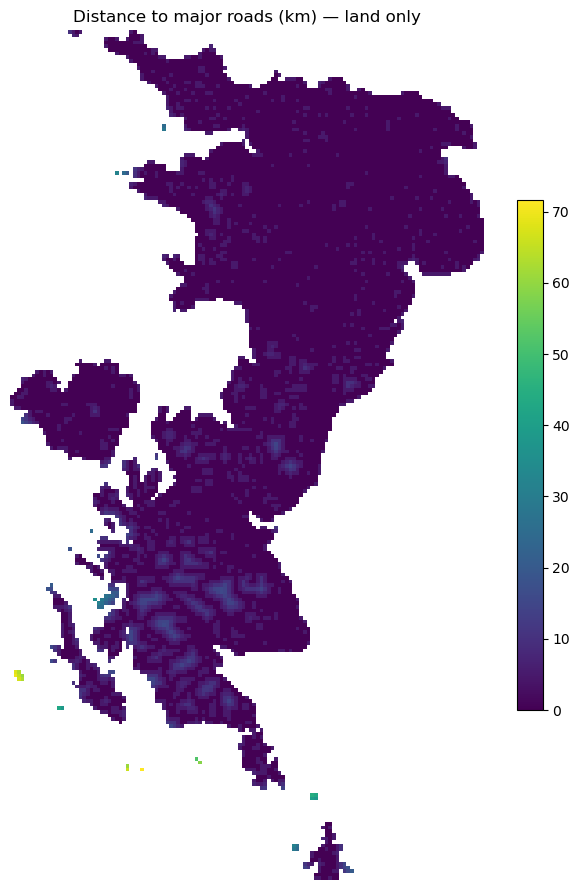

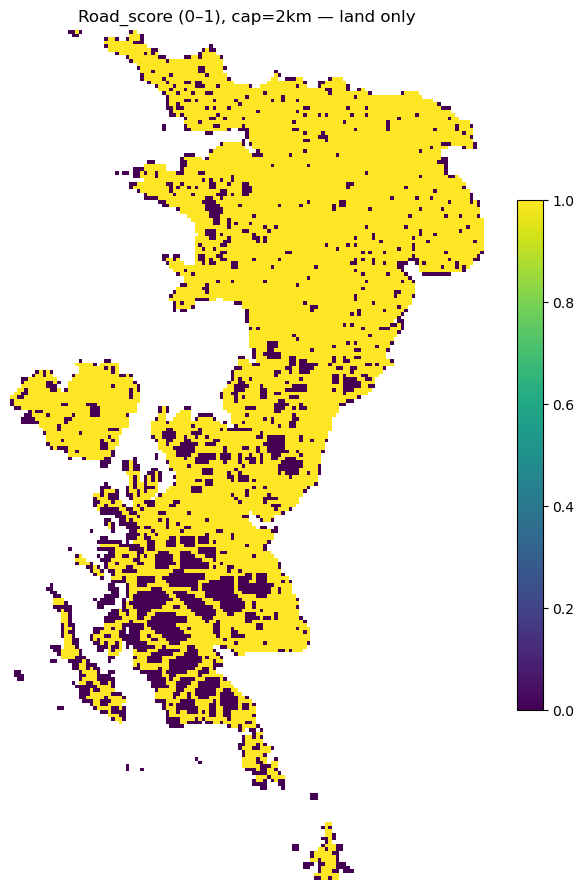

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_major_roads_m.tif
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_road_score.tif
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_dist_to_major_roads_m.png
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_road_score.png


In [15]:
BASE = "/Users/jsh/Desktop/assignment2 spatial"

template_tif = os.path.join(BASE, "uk_cf_score.tif")
boundary_fp  = os.path.join(BASE, "uk boundary.geojson")
roads_gpkg   = os.path.join(BASE, "uk_major_roads_epsg3035.gpkg")

out_dist_tif  = os.path.join(BASE, "uk_dist_to_major_roads_m.tif")
out_score_tif = os.path.join(BASE, "uk_road_score.tif")
out_png_dist  = os.path.join(BASE, "uk_dist_to_major_roads_m.png")
out_png_score = os.path.join(BASE, "uk_road_score.png")

nodata_val = -9999.0


CAP_KM = 2.0    
CAP_M  = CAP_KM * 1000.0

BUFFER_M = 0.0   

with rasterio.open(template_tif) as src:
    meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    height, width = src.height, src.width

xres = abs(transform.a)
yres = abs(transform.e)
print("Template CRS:", crs, "Resolution:", xres, yres, "Shape:", (height, width))

meta_out = meta.copy()
meta_out.update(dtype="float32", nodata=nodata_val, count=1)

# land mask
uk = gpd.read_file(boundary_fp).to_crs(crs)
land_mask = rasterize(
    [(geom, 1) for geom in uk.geometry if geom is not None],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
).astype(bool)

# roads
roads = gpd.read_file(roads_gpkg).to_crs(crs)
print("Road features:", len(roads))

geoms = []
for g in roads.geometry:
    if g is None or g.is_empty:
        continue
    if BUFFER_M > 0:
        geoms.append(g.buffer(BUFFER_M))
    else:
        geoms.append(g)

roads_ras = rasterize(
    [(geom, 1) for geom in geoms],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8"
)

print("Road raster coverage (% of cells):", 100.0 * roads_ras.mean())

# distance (meters)
binary = np.ones((height, width), dtype=np.uint8)
binary[roads_ras == 1] = 0

dist_m = distance_transform_edt(binary, sampling=(yres, xres)).astype("float32")
dist_m = np.where(land_mask, dist_m, nodata_val)

with rasterio.open(out_dist_tif, "w", **meta_out) as dst:
    dst.write(dist_m, 1)

# score
valid = (dist_m != nodata_val) & np.isfinite(dist_m)

dist_cap = np.minimum(dist_m, CAP_M)
road_score = np.where(valid, 1.0 - (dist_cap / CAP_M), nodata_val).astype("float32")
road_score = np.clip(road_score, 0, 1)

with rasterio.open(out_score_tif, "w", **meta_out) as dst:
    dst.write(road_score, 1)

# stats
vals = road_score[valid]
print("Score min/median/mean/max:",
      float(np.min(vals)),
      float(np.median(vals)),
      float(np.mean(vals)),
      float(np.max(vals)))
print("Share with score==1 (dist=0):", float(np.mean(vals >= 0.999)))
print("Share with score==0 (dist>=cap):", float(np.mean(vals <= 1e-6)))

# plots
plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, dist_m/1000.0, np.nan))
plt.title("Distance to major roads (km) — land only")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_png_dist, dpi=300)
plt.show()

plt.figure(figsize=(7, 9))
plt.imshow(np.where(valid, road_score, np.nan), vmin=0, vmax=1)
plt.title(f"Road_score (0–1), cap={CAP_KM:.0f}km — land only")
plt.axis("off")
plt.colorbar(shrink=0.6)
plt.tight_layout()
plt.savefig(out_png_score, dpi=300)
plt.show()

print("Saved:", out_dist_tif)
print("Saved:", out_score_tif)
print("Saved:", out_png_dist)
print("Saved:", out_png_score)


Saved: /Users/jsh/Desktop/assignment2 spatial/uk_suitability.tif


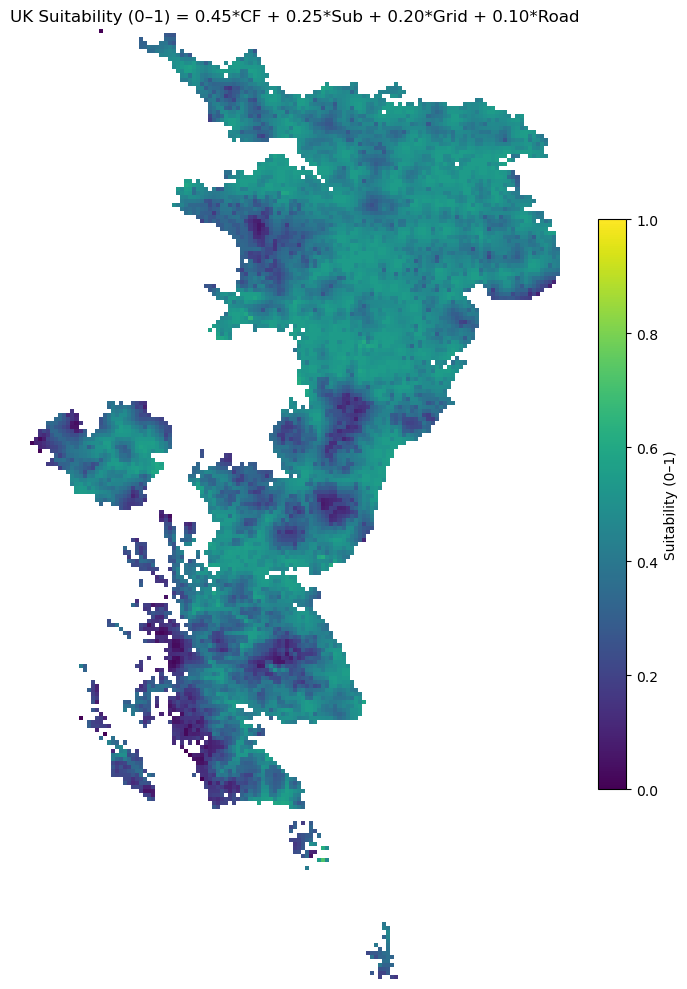

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_suitability.png


In [16]:
from rasterio.warp import reproject, Resampling
BASE = "/Users/jsh/Desktop/assignment2 spatial"

cf_tif   = os.path.join(BASE, "uk_cf_score.tif")
grid_tif = os.path.join(BASE, "uk_grid_score.tif")
sub_tif  = os.path.join(BASE, "uk_substation_score_combined.tif")
road_tif = os.path.join(BASE, "uk_road_score.tif")

out_tif = os.path.join(BASE, "uk_suitability.tif")
out_png = os.path.join(BASE, "uk_suitability.png")

W_CF, W_SUB, W_GRID, W_ROAD = 0.45, 0.25, 0.20, 0.10
nodata_out = -9999.0

def read_align_to_template(src_path, tmpl_profile):
    """Read raster; if grid differs, reproject/resample to template grid."""
    with rasterio.open(src_path) as src:
        src_arr = src.read(1).astype("float32")
        src_nodata = src.nodata
        if src_nodata is not None:
            src_arr = np.where(src_arr == src_nodata, np.nan, src_arr)

        # If already aligned, return directly
        same = (
            src.crs == tmpl_profile["crs"]
            and src.transform == tmpl_profile["transform"]
            and src.width == tmpl_profile["width"]
            and src.height == tmpl_profile["height"]
        )
        if same:
            return src_arr

        dst = np.full((tmpl_profile["height"], tmpl_profile["width"]), np.nan, dtype="float32")
        reproject(
            source=src_arr,
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=tmpl_profile["transform"],
            dst_crs=tmpl_profile["crs"],
            resampling=Resampling.bilinear 
        )
        return dst


with rasterio.open(cf_tif) as tmpl:
    tmpl_profile = tmpl.profile.copy()
    cf = tmpl.read(1).astype("float32")
    if tmpl.nodata is not None:
        cf = np.where(cf == tmpl.nodata, np.nan, cf)


grid = read_align_to_template(grid_tif, tmpl_profile)
sub  = read_align_to_template(sub_tif,  tmpl_profile)
road = read_align_to_template(road_tif, tmpl_profile)


suit = W_CF*cf + W_SUB*sub + W_GRID*grid + W_ROAD*road


prof_out = tmpl_profile.copy()
prof_out.update(dtype="float32", nodata=nodata_out, count=1, compress="lzw")

suit_out = np.where(np.isfinite(suit), suit, nodata_out).astype("float32")

with rasterio.open(out_tif, "w", **prof_out) as dst:
    dst.write(suit_out, 1)

print("Saved:", out_tif)

plt.figure(figsize=(8, 10))
plt.imshow(np.where(suit_out == nodata_out, np.nan, suit_out), vmin=0, vmax=1)
plt.title("UK Suitability (0–1) = 0.45*CF + 0.25*Sub + 0.20*Grid + 0.10*Road")
plt.axis("off")
plt.colorbar(shrink=0.6, label="Suitability (0–1)")
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()

print("Saved:", out_png)


Wind speed (land) percentiles:
P5=3.395, P95=5.700
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_cf_score_robust.tif
CF_score robust stats (land):
min/median/mean/max: 0.0 0.35542938113212585 0.40044963359832764 1.0


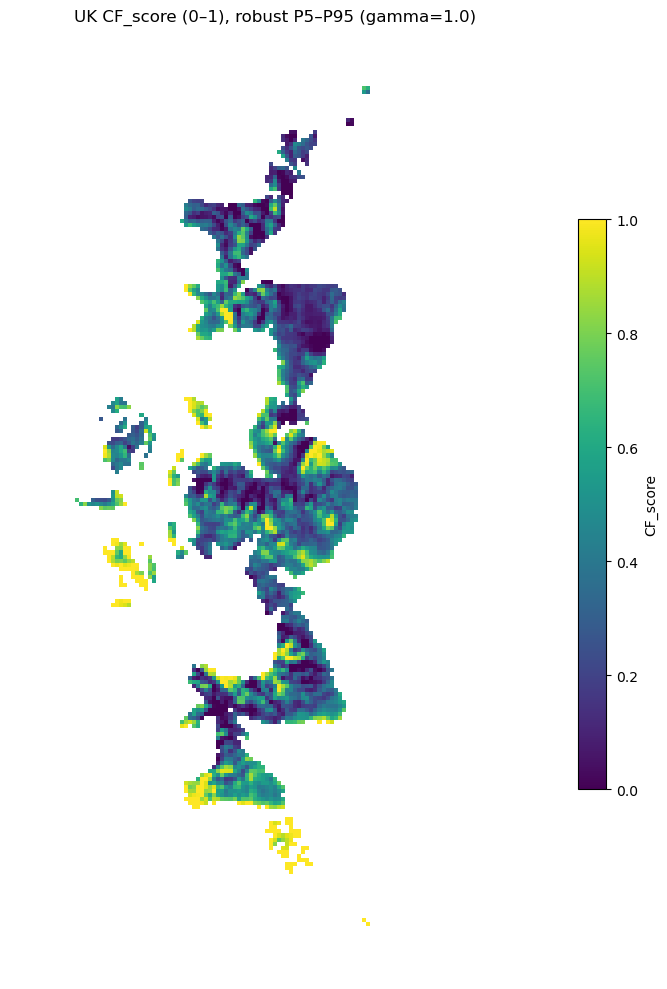

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_cf_score_robust.png


In [17]:
import xarray as xr
import rioxarray
from rasterio import features
from rasterio.transform import from_origin

BASE = "/Users/jsh/Desktop/assignment2 spatial"
nc_fp = os.path.join(BASE, "wind_speed.nc")
boundary_fp = os.path.join(BASE, "uk boundary.geojson")

out_tif = os.path.join(BASE, "uk_cf_score_robust.tif")
out_png = os.path.join(BASE, "uk_cf_score_robust.png")


P_LOW  = 5   
P_HIGH = 95   
GAMMA  = 1.0  

ds = xr.open_dataset(nc_fp)
var = "wind_speed"
da = ds[var]  


ws = da.mean("season", skipna=True)


ws = ws.rio.write_crs("EPSG:27700", inplace=False)
ws = ws.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)


ukb = gpd.read_file(boundary_fp).to_crs("EPSG:27700")
geom = [g.__geo_interface__ for g in ukb.geometry]


x = ws["x"].values
y = ws["y"].values

dx = float(np.median(np.diff(x)))
dy = float(np.median(np.diff(y)))

transform = from_origin(x.min() - dx/2, y.max() + dy/2, dx, abs(dy))

h, w = ws.shape
land_mask = features.geometry_mask(
    geom,
    out_shape=(h, w),
    transform=transform,
    invert=True,      # True = 陆地为 True
    all_touched=True
)

ws_arr = ws.values.astype("float32")
ws_land = np.where(land_mask, ws_arr, np.nan)


p_lo = np.nanpercentile(ws_land, P_LOW)
p_hi = np.nanpercentile(ws_land, P_HIGH)

print("Wind speed (land) percentiles:")
print(f"P{P_LOW}={p_lo:.3f}, P{P_HIGH}={p_hi:.3f}")


ws_clip = np.clip(ws_land, p_lo, p_hi)
cf_score = (ws_clip - p_lo) / (p_hi - p_lo + 1e-12)


if GAMMA != 1.0:
    cf_score = np.power(cf_score, GAMMA)


nodata = -9999.0
cf_out = np.where(np.isfinite(cf_score), cf_score, nodata).astype("float32")


profile = {
    "driver": "GTiff",
    "height": h,
    "width": w,
    "count": 1,
    "dtype": "float32",
    "crs": "EPSG:27700",
    "transform": transform,
    "nodata": nodata,
    "compress": "lzw"
}

with rasterio.open(out_tif, "w", **profile) as dst:
    dst.write(cf_out, 1)

print("Saved:", out_tif)


vals = cf_out[cf_out != nodata]
print("CF_score robust stats (land):")
print("min/median/mean/max:",
      float(np.nanmin(vals)),
      float(np.nanmedian(vals)),
      float(np.nanmean(vals)),
      float(np.nanmax(vals)))

plt.figure(figsize=(8,10))
plt.imshow(np.where(cf_out==nodata, np.nan, cf_out), vmin=0, vmax=1)
plt.title(f"UK CF_score (0–1), robust P{P_LOW}–P{P_HIGH} (gamma={GAMMA})")
plt.axis("off")
plt.colorbar(shrink=0.6, label="CF_score")
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()
print("Saved:", out_png)


Saved: /Users/jsh/Desktop/assignment2 spatial/uk_cf_score_percentile.tif


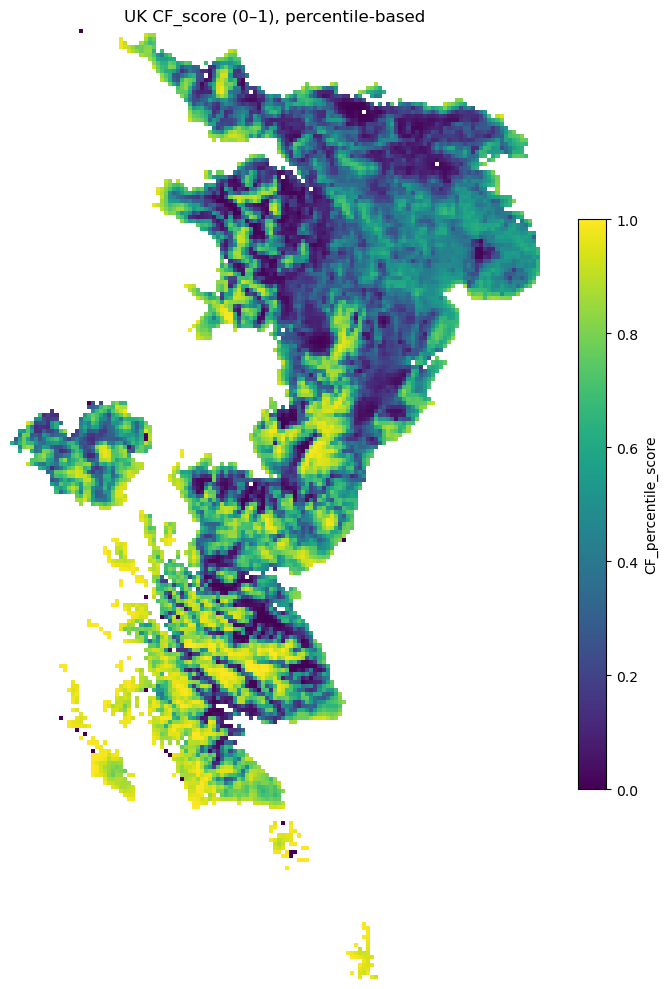

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_cf_score_percentile.png


In [20]:
BASE = "/Users/jsh/Desktop/assignment2 spatial"
in_tif  = os.path.join(BASE, "uk_cf_score.tif") 
out_tif = os.path.join(BASE, "uk_cf_score_percentile.tif")
out_png = os.path.join(BASE, "uk_cf_score_percentile.png")

nodata_out = -9999.0

with rasterio.open(in_tif) as src:
    arr = src.read(1).astype("float32")
    prof = src.profile.copy()
    nd = src.nodata


mask = (arr != nd) if nd is not None else np.isfinite(arr)
vals = arr[mask]


order = np.argsort(vals)
ranks = np.empty_like(vals, dtype="float32")
ranks[order] = np.linspace(0.0, 1.0, len(vals), dtype="float32")

arr_out = np.full(arr.shape, nodata_out, dtype="float32")
arr_out[mask] = ranks

prof.update(dtype="float32", nodata=nodata_out, compress="lzw", count=1)

with rasterio.open(out_tif, "w", **prof) as dst:
    dst.write(arr_out, 1)

print("Saved:", out_tif)


plt.figure(figsize=(8,10))
plt.imshow(np.where(arr_out==nodata_out, np.nan, arr_out), vmin=0, vmax=1)
plt.title("UK CF_score (0–1), percentile-based")
plt.axis("off")
plt.colorbar(shrink=0.6, label="CF_percentile_score")
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()
print("Saved:", out_png)


Robust stretch range: P5=0.0008, P95=0.1779
Saved: /Users/jsh/Desktop/assignment2 spatial/uk_cf_score_robust_p5_p95.tif


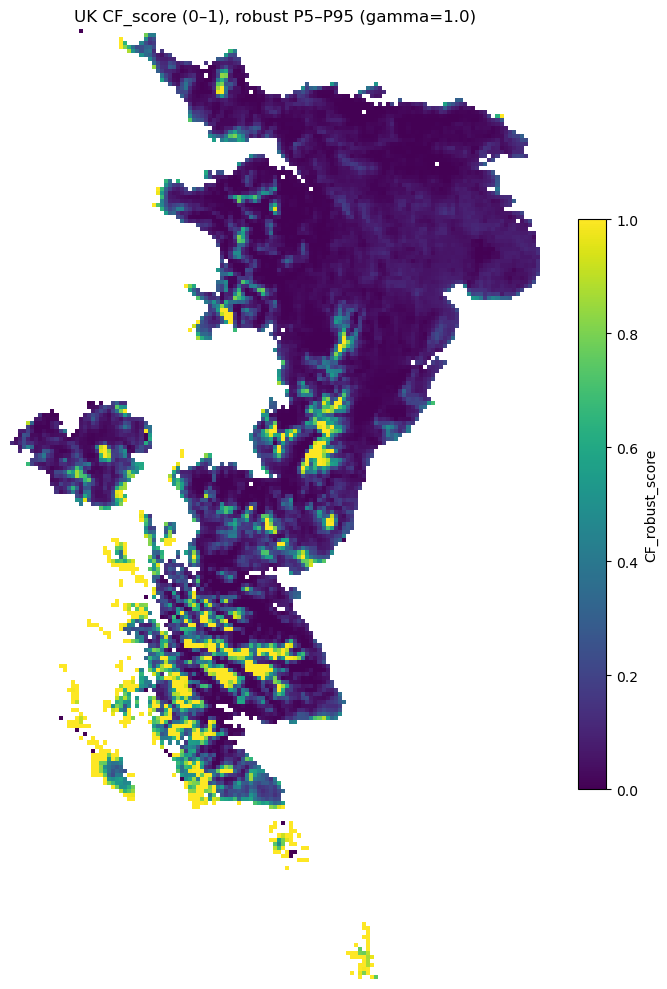

Saved: /Users/jsh/Desktop/assignment2 spatial/uk_cf_score_robust_p5_p95.png


In [21]:
BASE = "/Users/jsh/Desktop/assignment2 spatial"
in_tif  = os.path.join(BASE, "uk_cf_score.tif")  
out_tif = os.path.join(BASE, "uk_cf_score_robust_p5_p95.tif")
out_png = os.path.join(BASE, "uk_cf_score_robust_p5_p95.png")


P_LOW, P_HIGH = 5, 95    
GAMMA = 1.0              
nodata_out = -9999.0

with rasterio.open(in_tif) as src:
    arr = src.read(1).astype("float32")
    prof = src.profile.copy()
    nd = src.nodata

mask = (arr != nd) if nd is not None else np.isfinite(arr)
vals = arr[mask]

p_lo = np.percentile(vals, P_LOW)
p_hi = np.percentile(vals, P_HIGH)
print(f"Robust stretch range: P{P_LOW}={p_lo:.4f}, P{P_HIGH}={p_hi:.4f}")

x = np.clip(vals, p_lo, p_hi)
x = (x - p_lo) / (p_hi - p_lo + 1e-12)

if GAMMA != 1.0:
    x = np.power(x, GAMMA)

arr_out = np.full(arr.shape, nodata_out, dtype="float32")
arr_out[mask] = x

prof.update(dtype="float32", nodata=nodata_out, compress="lzw", count=1)

with rasterio.open(out_tif, "w", **prof) as dst:
    dst.write(arr_out, 1)

print("Saved:", out_tif)

# plot
plt.figure(figsize=(8,10))
plt.imshow(np.where(arr_out==nodata_out, np.nan, arr_out), vmin=0, vmax=1)
plt.title(f"UK CF_score (0–1), robust P{P_LOW}–P{P_HIGH} (gamma={GAMMA})")
plt.axis("off")
plt.colorbar(shrink=0.6, label="CF_robust_score")
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()
print("Saved:", out_png)


In [28]:
BASE = "/Users/jsh/Desktop/assignment2 spatial"  

top20_gjson = os.path.join(BASE, "top20_suitability_points.geojson")
boundary_fp = os.path.join(BASE, "uk boundary.geojson")  
out_png = os.path.join(BASE, "top20_points_stars_only.png")


pts = gpd.read_file(top20_gjson)
uk  = gpd.read_file(boundary_fp)


pts = pts.to_crs(uk.crs)


uk_outer = uk.dissolve()


fig, ax = plt.subplots(figsize=(6, 8))
uk_outer.boundary.plot(ax=ax, color="black", linewidth=0.6)


pts.plot(
    ax=ax,
    marker="*",
    color="gold",
    edgecolor="black",
    linewidth=0.6,
    markersize=120,
    zorder=5
)


if "rank" in pts.columns:
    for _, r in pts.iterrows():
        ax.annotate(
            text=str(r["rank"]),
            xy=(r.geometry.x, r.geometry.y),
            xytext=(3, 3),
            textcoords="offset points",
            fontsize=8
        )

ax.set_title("Top 20 candidate sites (AHP suitability)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.close()

print("[OK] saved:", out_png)


[OK] saved: /Users/jsh/Desktop/assignment2 spatial/top20_points_stars_only.png


In [31]:
BASE = "/Users/jsh/Desktop/assignment2 spatial"  

pts_fp = os.path.join(BASE, "top20_spaced_points.geojson")
uk_fp  = os.path.join(BASE, "uk boundary.geojson")

out_png = os.path.join(BASE, "uk_top20_spaced_stars_FIXED.png")


uk = gpd.read_file(uk_fp)
uk_outer = uk.dissolve()  


pts = gpd.read_file(pts_fp)


minx, miny, maxx, maxy = pts.total_bounds
looks_projected = (abs(minx) > 180) or (abs(maxx) > 180) or (abs(miny) > 90) or (abs(maxy) > 90)

if pts.crs is None:
    if looks_projected:
        pts = pts.set_crs(uk.crs, allow_override=True)
    else:
        pts = pts.set_crs("EPSG:4326", allow_override=True).to_crs(uk.crs)
else:
    if str(pts.crs).endswith("4326") and looks_projected:
        pts = pts.set_crs(uk.crs, allow_override=True)  # 覆盖成正确 CRS（不要投影转换）
    else:
        pts = pts.to_crs(uk.crs)


fig, ax = plt.subplots(figsize=(7, 9))


uk_outer.boundary.plot(ax=ax, color="black", linewidth=0.9, zorder=1)

pts.plot(
    ax=ax,
    marker="*",
    markersize=260,
    color="gold",
    edgecolor="black",
    linewidth=0.8,
    zorder=10
)


if "rank" in pts.columns:
    for _, r in pts.iterrows():
        ax.annotate(
            text=str(int(r["rank"])),
            xy=(r.geometry.x, r.geometry.y),
            xytext=(4, 4),
            textcoords="offset points",
            fontsize=9,
            color="black",
            zorder=11
        )

ux0, uy0, ux1, uy1 = uk_outer.total_bounds
padx = (ux1 - ux0) * 0.05
pady = (uy1 - uy0) * 0.05
ax.set_xlim(ux0 - padx, ux1 + padx)
ax.set_ylim(uy0 - pady, uy1 + pady)

ax.set_title("Top 20 spaced candidate sites (AHP suitability)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.close()

print("[OK] saved:", out_png)
print("[DEBUG] pts bounds:", pts.total_bounds, " CRS:", pts.crs)



[OK] saved: /Users/jsh/Desktop/assignment2 spatial/uk_top20_spaced_stars_FIXED.png
[DEBUG] pts bounds: [ 127500.  212500.  442500. 1132500.]  CRS: EPSG:4326


In [35]:
BASE = "/Users/jsh/Desktop/assignment2 spatial"  

pts_fp = os.path.join(BASE, "top20_spaced_points.geojson")
uk_fp  = os.path.join(BASE, "uk boundary.geojson")

out_png = os.path.join(BASE, "uk_top20_spaced_stars_ON_MAP.png")

def infer_crs_from_bounds(bounds):
    """Infer CRS from numeric ranges."""
    minx, miny, maxx, maxy = bounds
    # looks like lon/lat
    if (-20 <= minx <= 20) and (-20 <= maxx <= 20) and (40 <= miny <= 70) and (40 <= maxy <= 70):
        return "EPSG:4326"
    # looks like British National Grid meters
    if (0 <= minx <= 800000) and (0 <= maxx <= 800000) and (0 <= miny <= 1400000) and (0 <= maxy <= 1400000):
        return "EPSG:27700"
    # looks like ETRS89 / LAEA Europe meters (very rough)
    if (1000000 <= minx <= 7000000) and (1000000 <= maxx <= 7000000) and (1000000 <= miny <= 6000000) and (1000000 <= maxy <= 6000000):
        return "EPSG:3035"
    return None

uk = gpd.read_file(uk_fp)

if uk.crs is None:
    uk_guess = infer_crs_from_bounds(uk.total_bounds)
    if uk_guess is None:
        uk_guess = "EPSG:4326"
    uk = uk.set_crs(uk_guess, allow_override=True)

uk_outer = uk.dissolve()

pts = gpd.read_file(pts_fp)
pts = pts.set_crs("EPSG:27700", allow_override=True)

pts = pts.to_crs(uk.crs)

fig, ax = plt.subplots(figsize=(7, 9))

uk_outer.boundary.plot(ax=ax, color="black", linewidth=0.9, zorder=1)

pts.plot(
    ax=ax,
    marker="*",
    markersize=60,
    color="gold",
    edgecolor="black",
    linewidth=0.8,
    zorder=10
)

if "rank" in pts.columns:
    for _, r in pts.iterrows():
        ax.annotate(
            text=str(int(r["rank"])),
            xy=(r.geometry.x, r.geometry.y),
            xytext=(4, 4),
            textcoords="offset points",
            fontsize=9,
            color="black",
            zorder=11
        )

minx, miny, maxx, maxy = uk_outer.total_bounds
padx = (maxx - minx) * 0.05
pady = (maxy - miny) * 0.05
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

ax.set_title("Top 20 spaced candidate sites (AHP suitability)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.close()

print("[OK] saved:", out_png)
print("[DEBUG] UK CRS:", uk.crs, "UK bounds:", uk_outer.total_bounds)
print("[DEBUG] PTS CRS:", pts.crs, "PTS bounds:", pts.total_bounds)


[OK] saved: /Users/jsh/Desktop/assignment2 spatial/uk_top20_spaced_stars_ON_MAP.png
[DEBUG] UK CRS: EPSG:4326 UK bounds: [-8.64999583 49.86479264  1.76370561 60.86076581]
[DEBUG] PTS CRS: EPSG:4326 PTS bounds: [-6.5535972  51.76882801 -1.23813683 60.07498239]


Saved:
 - /Users/jsh/Desktop/assignment2 spatial/top20_spaced_points_ON_LAND.csv
 - /Users/jsh/Desktop/assignment2 spatial/top20_spaced_points_ON_LAND.geojson


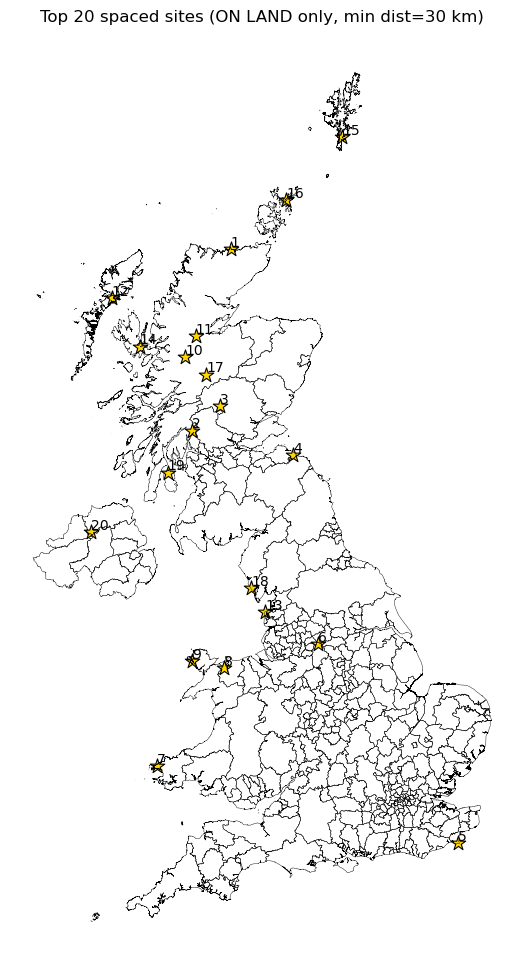

 - /Users/jsh/Desktop/assignment2 spatial/top20_spaced_points_ON_LAND.png


In [40]:
Base= "/Users/jsh/Desktop/assignment2 spatial"

SCORE_TIF = os.path.join(BASE, "uk_suitability_score_ahp.tif")                
AVAIL_MASK_TIF = os.path.join(BASE, "uk_available_mask_final.tif") 
UK_BOUNDARY = os.path.join(BASE, "uk boundary.geojson")

OUT_CSV = os.path.join(BASE, "top20_spaced_points_ON_LAND.csv")
OUT_GEOJSON = os.path.join(BASE, "top20_spaced_points_ON_LAND.geojson")
OUT_PNG = os.path.join(BASE, "top20_spaced_points_ON_LAND.png")

TOP_N = 20
MIN_DIST_KM = 30
MIN_DIST_M = MIN_DIST_KM * 1000
TOPK_CANDIDATES = 200000


MASK_AVAILABLE_VALUE = 1   


with rasterio.open(SCORE_TIF) as src:
    score = src.read(1).astype("float32")
    score_meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    height, width = src.height, src.width
    score_nodata = src.nodata

valid_score = np.isfinite(score)
if score_nodata is not None:
    valid_score &= (score != score_nodata)


with rasterio.open(AVAIL_MASK_TIF) as msk:
    src_mask = msk.read(1)
    src_mask_crs = msk.crs
    src_mask_transform = msk.transform
    src_mask_nodata = msk.nodata

    dst_mask = np.zeros((height, width), dtype=src_mask.dtype)

    reproject(
        source=src_mask,
        destination=dst_mask,
        src_transform=src_mask_transform,
        src_crs=src_mask_crs,
        dst_transform=transform,
        dst_crs=crs,
        resampling=Resampling.nearest,   
        src_nodata=src_mask_nodata,
        dst_nodata=src_mask_nodata
    )


valid_avail = (dst_mask == MASK_AVAILABLE_VALUE)



uk = gpd.read_file(UK_BOUNDARY)
if uk.crs != crs:
    uk = uk.to_crs(crs)

uk_shapes = [(geom, 1) for geom in uk.geometry if geom is not None and not geom.is_empty]
land_mask = rasterize(
    uk_shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=False
).astype(bool)


candidate_mask = valid_score & valid_avail & land_mask

cand_idx = np.flatnonzero(candidate_mask.ravel())
cand_scores = score.ravel()[cand_idx]

k = min(TOPK_CANDIDATES, cand_idx.size)
topk_order = np.argpartition(-cand_scores, kth=k-1)[:k]
topk_idx = cand_idx[topk_order]
topk_scores = score.ravel()[topk_idx]

sort_order = np.argsort(-topk_scores)
topk_idx = topk_idx[sort_order]
topk_scores = topk_scores[sort_order]



def idx_to_xy(flat_idx, transform, width):
    row = flat_idx // width
    col = flat_idx % width
    x, y = rasterio.transform.xy(transform, row, col, offset="center")
    return row, col, float(x), float(y)

selected = []
min_dist2 = MIN_DIST_M ** 2

for flat_i, sc in zip(topk_idx, topk_scores):
    row, col, x, y = idx_to_xy(flat_i, transform, width)

    ok = True
    for s in selected:
        dx = x - s["x"]
        dy = y - s["y"]
        if (dx*dx + dy*dy) < min_dist2:
            ok = False
            break

    if ok:
        selected.append({"rank": len(selected)+1, "score": float(sc), "row": int(row), "col": int(col), "x": x, "y": y})
        if len(selected) >= TOP_N:
            break

if len(selected) < TOP_N:
    print(f"[WARN] 只选到了 {len(selected)}/{TOP_N} 个点。")
    print("尝试：减小 MIN_DIST_KM，或增大 TOPK_CANDIDATES，或 all_touched=True。")


df = pd.DataFrame(selected)
df.to_csv(OUT_CSV, index=False)

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["x"], df["y"]),
    crs=crs
)
gdf.to_file(OUT_GEOJSON, driver="GeoJSON")

print("Saved:")
print(" -", OUT_CSV)
print(" -", OUT_GEOJSON)

fig, ax = plt.subplots(figsize=(7, 10))
uk.boundary.plot(ax=ax, linewidth=0.3, color="black")
gdf.plot(ax=ax, marker="*", markersize=120, edgecolor="black", facecolor="gold", linewidth=0.8)

for _, r in gdf.iterrows():
    ax.text(r.geometry.x, r.geometry.y, str(int(r["rank"])), fontsize=10, ha="left", va="bottom")

ax.set_title(f"Top {TOP_N} spaced sites (ON LAND only, min dist={MIN_DIST_KM} km)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
plt.show()

print(" -", OUT_PNG)
